In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [1]:
import os
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont, ExifTags
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
ycb_dataset_path = "models/ycb_resized"
masks_path = "masks" # path inside each of the ycb dataset object folders

object_names = [f.name for f in os.scandir(ycb_dataset_path) if f.is_dir()]
object_paths = [f.path for f in os.scandir(ycb_dataset_path) if f.is_dir()]
object_names = sorted(object_names)
object_paths = sorted(object_paths)



Image name: N1_0, Mask name: N1_0


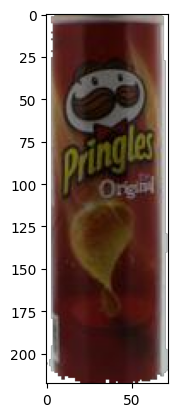

In [3]:
# see a sample
for i in range(len(object_names)):
    object_path = object_paths[i]
    masks_path = os.path.join(ycb_dataset_path, object_names[i], "masks")
    
    # get the name of the mask
    image_files = [f.name for f in os.scandir(object_path) if f.is_file()]
    try:
        mask_files = [f.name for f in os.scandir(masks_path) if f.is_file()]
    except FileNotFoundError:
        print(f"No mask found for {object_names[i]}")
        continue
    
    image_files = sorted(image_files)
    mask_files = sorted(mask_files)
    
    for i in range(len(mask_files)):
        # check image and mask names and match them
        # get only name of file
        image_name = image_files[i].split(".")[0]
        mask_name = mask_files[i].split(".")[0]
        
        # eliminate "_mask" at the end of mask name
        mask_name = mask_name[:-5]
        
        print(f"Image name: {image_name}, Mask name: {mask_name}")
        
        if image_name != mask_name:
            print("Image and mask names do not match.")
            break
            
        # load image and mask
        image = Image.open(os.path.join(object_path, image_files[i]))
        mask = Image.open(os.path.join(masks_path, mask_files[i]))
        
        # Invert mask (black to white, white to black)
        mask = np.invert(np.array(mask))
        
        # apply mask to image
        image = np.array(image)
        image[mask == 0] = 0
        
        # crop the image to only where the mask is
        ret, thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
        image_pt_coords = np.argwhere(thresh)
        min_y = min(image_pt_coords[:, 0])
        min_x = min(image_pt_coords[:, 1])
        max_y = max(image_pt_coords[:, 0])
        max_x = max(image_pt_coords[:, 1])
        
        image = image[min_y:max_y, min_x:max_x]
        
        # convert the black to transparent (png)
        alpha = np.sum(image, axis=2)
        alpha[alpha > 0] = 255
        alpha = alpha.astype(np.uint8)
        image = np.dstack((image, alpha))
        
        image = Image.fromarray(image)
        image.save("image.png")
        
        # display image
        plt.imshow(image)
        plt.show()
        break
        
    break
    

### CUT PNGs ###

In [8]:
png_dataset_path = "models/ycb_resized_png"
os.makedirs(png_dataset_path, exist_ok=True)

for i in range(len(object_names)):
    object_path = object_paths[i]
    masks_path = os.path.join(ycb_dataset_path, object_names[i], "masks")
    
    # get the name of the mask
    image_files = [f.name for f in os.scandir(object_path) if f.is_file()]
    try:
        mask_files = [f.name for f in os.scandir(masks_path) if f.is_file()]
    except FileNotFoundError:
        print(f"No mask found for {object_names[i]}")
        continue
    
    png_object_path = os.path.join(png_dataset_path, object_names[i])
    if not os.path.exists(png_object_path):
        os.makedirs(png_object_path)
    
    # sort to match the names
    image_files = sorted(image_files)
    
    # sort masks without _mask.pbm
    mask_files = [mask_file[:-9] for mask_file in mask_files]
    mask_files = sorted(mask_files)
    
    # return the original mask path
    mask_files = [mask_file + "_mask.pbm" for mask_file in mask_files]
    
    progress = tqdm(total=len(mask_files), desc=f"Processing pngs for {object_names[i]}")
    
    for i in range(len(mask_files)):
        # check image and mask names and match them
        # get only name of file
        progress.update(1)
        # print(image_files[i], mask_files[i])
        image_name = image_files[i].split(".")[0]
        mask_name = mask_files[i].split(".")[0]
        
        # eliminate "_mask" at the end of mask name
        mask_name = mask_name[:-5]
        
        # print(f"Image name: {image_name}, Mask name: {mask_name}")
        
        if image_name != mask_name:
            print("Image and mask names do not match.")
            break
            
        # load image and mask
        image = Image.open(os.path.join(object_path, image_files[i]))
        mask = Image.open(os.path.join(masks_path, mask_files[i]))
        
        # Invert mask (black to white, white to black)
        mask = np.invert(np.array(mask))
        
        # apply mask to image
        image = np.array(image)
        image[mask == 0] = 0
        
        # crop the image to only where the mask is
        ret, thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
        image_pt_coords = np.argwhere(thresh)
        min_y = min(image_pt_coords[:, 0])
        min_x = min(image_pt_coords[:, 1])
        max_y = max(image_pt_coords[:, 0])
        max_x = max(image_pt_coords[:, 1])
        
        image = image[min_y:max_y, min_x:max_x]
        
        # convert the black to transparent (png)
        alpha = np.sum(image, axis=2)
        alpha[alpha > 0] = 255
        alpha = alpha.astype(np.uint8)
        image = np.dstack((image, alpha))
        
        image = Image.fromarray(image)
        
        
        # change the file extension to png
        image_files[i] = image_files[i].split(".")[0] + ".png"
        
        image.save(os.path.join(png_object_path, image_files[i]))
    
    progress.close()
        
    

Processing pngs for 001_chips_can:   0%|          | 0/200 [00:00<?, ?it/s]